In [1]:
import numpy as np
import polytope as pc
from itertools import combinations

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.mdp import *

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

sys_n = sys_lti.normalize()

In [2]:
# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))


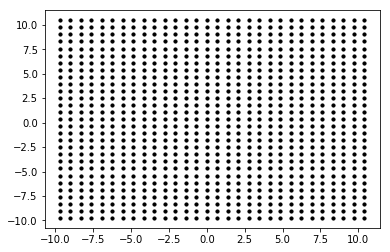

In [4]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)

abstr = LTIAbstraction(sys_n, d, un=4)

in_regions, nin_regions = abstr.map_dfa_inputs(regions)

fig = plt.figure()
abstr.plot(fig)

In [5]:
formula = '( ( ! avoid U target ) & ( F avoid ) )'

def subsets(collection):
    for i in range(len(collection)+1):
        it = combinations(collection, i)
        try:
            while True:
                yield(list(next(it)))
        except StopIteration:
            pass
    raise StopIteration

def connection(s_x):
    s = s_x[0]
    if s == abstr.mdp.N-1:
        return set([ (), ])
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s]:
            know_in.append(reg)
        if nin_regions[reg][s]:
            know_out.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
            
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])

pol = solve_ltl_cosafe(abstr.mdp, formula, connection)
print pol.V

[ 0.97092  1.       0.9803  ...,  1.       0.       0.     ]
